In [ ]:
# STEP 1: Install kaggle CLI if not already installed
!pip install -q kaggle

# STEP 2: Upload your Kaggle API key
from google.colab import files
uploaded = files.upload()  # Upload kaggle.json here

# STEP 3: Move kaggle.json to the correct location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# STEP 4: Download the Bleached Corals Detection dataset
!kaggle datasets download -d sonainjamil/bleached-corals-detection

# STEP 5: Unzip the dataset
!unzip -q bleached-corals-detection.zip -d coral_data

# STEP 6: View contents
import os
os.listdir("coral_data")


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/sonainjamil/bleached-corals-detection
License(s): Attribution 4.0 International (CC BY 4.0)


['Train']

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers, Model
import os
import shutil
import random

# === STEP 1: Organize dataset (split train/val/test) ===

base_dir = "/content/coral_data/Train"
output_dir = "/content/coral_split"

classes = ['Bleached', 'Unbleached']
splits = ['train', 'val', 'test']
split_ratio = [0.7, 0.15, 0.15]  # 70-15-15 split

In [ ]:
# Clean old dirs
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

In [ ]:
# Split and copy
for cls in classes:
    img_dir = os.path.join(base_dir, cls)
    images = os.listdir(img_dir)
    random.shuffle(images)
    n_total = len(images)
    n_train = int(n_total * split_ratio[0])
    n_val = int(n_total * split_ratio[1])

    for i, img in enumerate(images):
        if i < n_train:
            split = 'train'
        elif i < n_train + n_val:
            split = 'val'
        else:
            split = 'test'
        src = os.path.join(img_dir, img)
        dst = os.path.join(output_dir, split, cls, img)
        shutil.copy(src, dst)

print("✅ Dataset split completed.")

✅ Dataset split completed.


In [ ]:
IMAGE_SIZE = 128
BATCH_SIZE = 32
print("📦 Loading datasets...")

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(output_dir, 'train'),
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary'
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(output_dir, 'val'),
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary'
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(output_dir, 'test'),
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

print("✅ Datasets loaded:")
print(f" - Train batches: {len(train_ds)}")
print(f" - Validation batches: {len(val_ds)}")
print(f" - Test batches: {len(test_ds)}")

📦 Loading datasets...
Found 238 files belonging to 2 classes.
Found 50 files belonging to 2 classes.
Found 54 files belonging to 2 classes.
✅ Datasets loaded:
 - Train batches: 8
 - Validation batches: 2
 - Test batches: 2


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, channels):
        super(SelfAttention, self).__init__()
        self.query = layers.Conv2D(channels // 8, kernel_size=1)
        self.key = layers.Conv2D(channels // 8, kernel_size=1)
        self.value = layers.Conv2D(channels, kernel_size=1)
        self.gamma = self.add_weight(name="gamma", shape=(), initializer='zeros', trainable=True)

    def call(self, x):
        b, h, w, c = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], tf.shape(x)[3]
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)
        q = tf.reshape(q, (b, h * w, -1))
        k = tf.reshape(k, (b, h * w, -1))
        v = tf.reshape(v, (b, h * w, -1))
        attn = tf.matmul(q, k, transpose_b=True)
        attn = tf.nn.softmax(attn, axis=-1)
        out = tf.matmul(attn, v)
        out = tf.reshape(out, (b, h, w, c))
        return self.gamma * out + x

In [ ]:
def get_model3(wd, rate, param_dict):
    print("🔧 Building Self-Attention model...")
    inputs = tf.keras.Input(shape=(param_dict['IMAGE_SIZE'], param_dict['IMAGE_SIZE'], 3))

    x = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(2)(x)
    x = SelfAttention(64)(x)

    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    x = SelfAttention(128)(x)

    x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    x = SelfAttention(256)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization(momentum=0.95, epsilon=0.005)(x)
    x = layers.Dropout(rate)(x)

    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization(momentum=0.95, epsilon=0.005)(x)
    x = layers.Dropout(rate)(x)

    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization(momentum=0.95, epsilon=0.005)(x)
    x = layers.Dropout(rate)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'AUC', 'Precision', 'Recall',
                           tf.keras.metrics.TruePositives(),
                           tf.keras.metrics.TrueNegatives(),
                           tf.keras.metrics.FalsePositives(),
                           tf.keras.metrics.FalseNegatives()])

    print("✅ Model built and compiled.")
    return model

In [ ]:
# === STEP 4: Train the model ===

params = {
    'IMAGE_SIZE': IMAGE_SIZE
}

model = get_model3(wd=1e-4, rate=0.3, param_dict=params)

print("🚀 Starting training...")

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=5)


🔧 Building Self-Attention model...
✅ Model built and compiled.
🚀 Starting training...
Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - AUC: 0.6711 - Precision: 0.6000 - Recall: 0.5970 - accuracy: 0.6323 - false_negatives_8: 29.3333 - false_positives_8: 27.3333 - loss: 0.9351 - true_negatives_8: 55.2222 - true_positives_8: 40.5556 - val_AUC: 0.5000 - val_Precision: 0.4600 - val_Recall: 1.0000 - val_accuracy: 0.4600 - val_false_negatives_8: 0.0000e+00 - val_false_positives_8: 27.0000 - val_loss: 11.2257 - val_true_negatives_8: 0.0000e+00 - val_true_positives_8: 23.0000
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - AUC: 0.9129 - Precision: 0.8442 - Recall: 0.7781 - accuracy: 0.8209 - false_negatives_8: 15.3333 - false_positives_8: 10.6667 - loss: 0.5417 - true_negatives_8: 69.5556 - true_positives_8: 56.8889 - val_AUC: 0.5000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5400 - val_false_negatives_8: 23.0000 - val_false_positives_8: 0.0000e+00 - val_loss: 21.6

In [ ]:
# Evaluate model
eval_results = model.evaluate(test_ds, return_dict=True)

# Print evaluation metrics in table format
print("\n📋 Evaluation Results:")
print("{:<25} {:<10}".format("Metric", "Value"))
print("-" * 35)
for k, v in eval_results.items():
    print("{:<25} {:.4f}".format(k, v))


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - AUC: 0.9841 - Precision: 0.9167 - Recall: 0.8486 - accuracy: 0.8966 - false_negatives_8: 3.0000 - false_positives_8: 1.6667 - loss: 0.4735 - true_negatives_8: 23.6667 - true_positives_8: 18.3333

📋 Evaluation Results:
Metric                    Value     
-----------------------------------
AUC                       0.9841
Precision                 0.9167
Recall                    0.8800
accuracy                  0.9074
false_negatives_8         3.0000
false_positives_8         2.0000
loss                      0.4391
true_negatives_8          27.0000
true_positives_8          22.0000


In [ ]:
model.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_96 (Conv2D)              │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention_24               │ (None, 64, 64, 64)     │         5,201 │
│ (SelfAttention)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_100 (Conv2D)             │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention_25               │ (None, 32, 32, 128)    │        20,641 │
│ (SelfAttention)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention_26               │ (None, 16, 16, 256)    │        82,241 │
│ (SelfAttention)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,601,758 (391.39 MB)

 Trainable params: 34,199,988 (130.46 MB)

 Non-trainable params: 1,792 (7.00 KB)

 Optimizer params: 68,399,978 (260.93 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


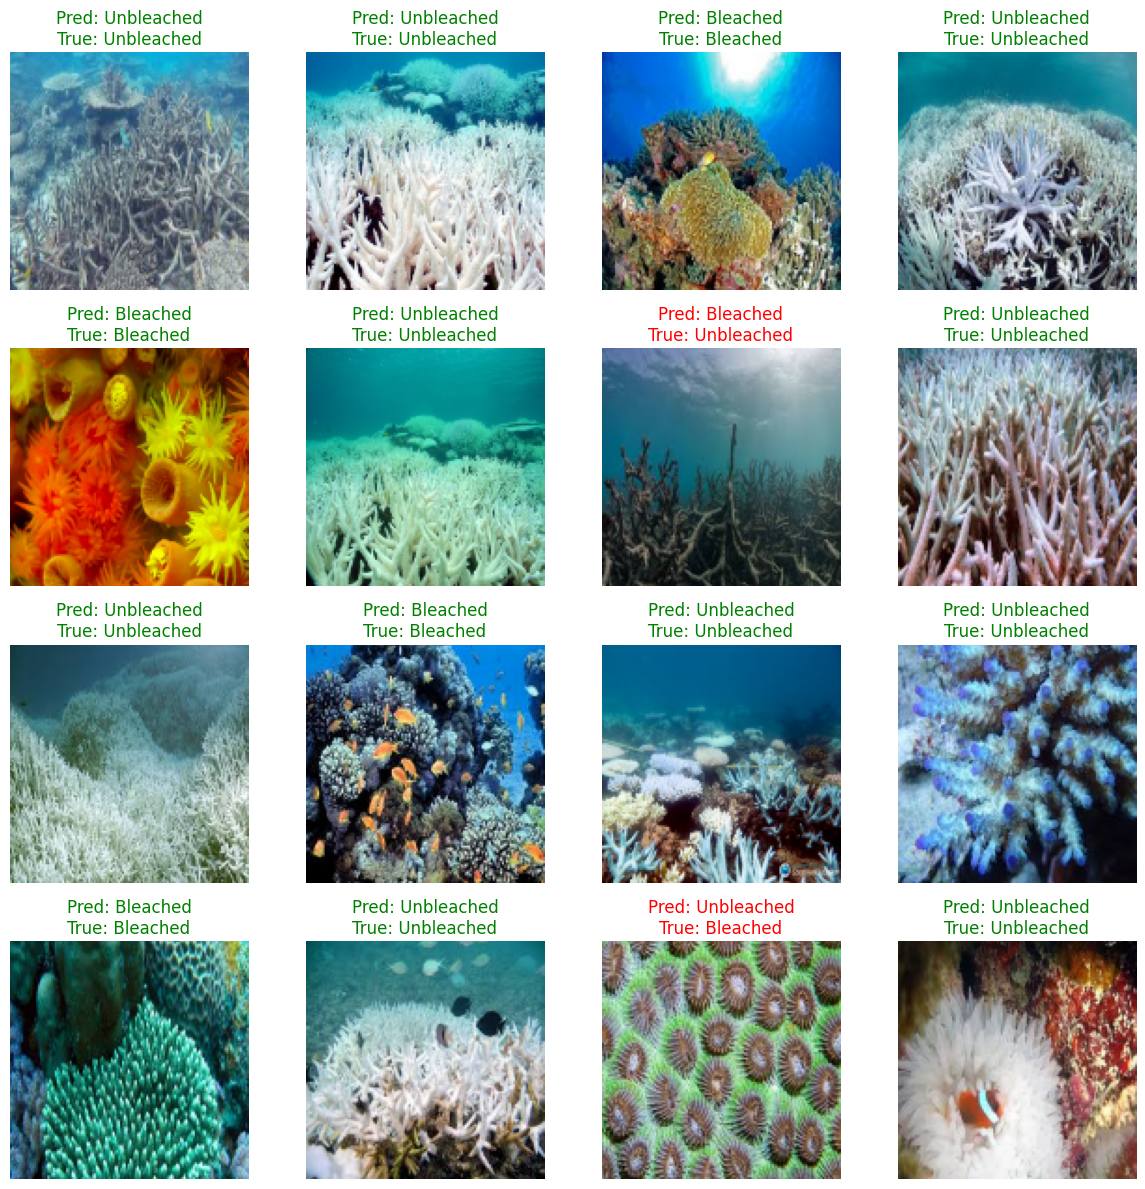

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch from the test set
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    preds = tf.squeeze(preds).numpy()
    break

# Set up grid size
num_images = min(16, len(images))  # 4x4 grid
plt.figure(figsize=(12, 12))

for i in range(num_images):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    true_label = "Bleached" if labels[i].numpy() == 1 else "Unbleached"
    pred_label = "Bleached" if preds[i] >= 0.5 else "Unbleached"
    color = "green" if true_label == pred_label else "red"
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
def get_model4(wd, rate, param_dict):
    print("🔧 Building ResNet50-based model (no self-attention)...")

    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(param_dict['IMAGE_SIZE'], param_dict['IMAGE_SIZE'], 3)
    )
    base_model.trainable = False  # Freeze pretrained layers

    inputs = tf.keras.Input(shape=(param_dict['IMAGE_SIZE'], param_dict['IMAGE_SIZE'], 3))
    x = tf.keras.applications.resnet50.preprocess_input(inputs)
    x = base_model(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization(momentum=0.95, epsilon=0.005)(x)
    x = layers.Dropout(rate)(x)

    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization(momentum=0.95, epsilon=0.005)(x)
    x = layers.Dropout(rate)(x)

    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization(momentum=0.95, epsilon=0.005)(x)
    x = layers.Dropout(rate)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'AUC', 'Precision', 'Recall',
                           tf.keras.metrics.TruePositives(),
                           tf.keras.metrics.TrueNegatives(),
                           tf.keras.metrics.FalsePositives(),
                           tf.keras.metrics.FalseNegatives()])

    print("✅ Model built and compiled.")
    return model


In [ ]:
# === STEP 4: Train the model ===

params = {
    'IMAGE_SIZE': IMAGE_SIZE
}

model = get_model4(wd=1e-4, rate=0.3, param_dict=params)

print("🚀 Starting training...")

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=50)


🔧 Building ResNet50-based model (no self-attention)...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
✅ Model built and compiled.
🚀 Starting training...
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - AUC: 0.7355 - Precision: 0.6497 - Recall: 0.7269 - accuracy: 0.6904 - false_negatives_9: 18.5556 - false_positives_9: 24.4444 - loss: 0.7995 - true_negatives_9: 56.6667 - true_positives_9: 52.7778 - val_AUC: 0.9702 - val_Precision: 0.7419 - val_Recall: 1.0000 - val_accuracy: 0.8400 - val_false_negatives_9: 0.0000e+00 - val_false_positives_9: 8.0000 - val_loss: 0.5295 - val_true_negatives_9: 19.0000 - val_true_positives_9: 23.0000
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - AUC: 0.9826 - Precision: 0.9784 - Recall: 0.9187 - accuracy: 0.9514 - false_negatives_9: 5.6667 - false_positives_9: 1.5556 - loss: 0.3007 - true_negatives_9: 79.0000 - true_positives_9: 66.2222 - val_AUC: 0.9799 - val_Precision: 0.8214 - val_Recall: 1.0000 - val_accuracy: 0.9000 - val_false_negatives_9: 0.

In [ ]:
# Evaluate model
eval_results = model.evaluate(test_ds, return_dict=True)

# Print evaluation metrics in table format
print("\n📋 Evaluation Results:")
print("{:<25} {:<10}".format("Metric", "Value"))
print("-" * 35)
for k, v in eval_results.items():
    print("{:<25} {:.4f}".format(k, v))


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - AUC: 0.9986 - Precision: 1.0000 - Recall: 0.9281 - accuracy: 0.9649 - false_negatives_9: 1.6667 - false_positives_9: 0.0000e+00 - loss: 0.2256 - true_negatives_9: 24.0000 - true_positives_9: 21.0000

📋 Evaluation Results:
Metric                    Value     
-----------------------------------
AUC                       0.9979
Precision                 1.0000
Recall                    0.9200
accuracy                  0.9630
false_negatives_9         2.0000
false_positives_9         0.0000
loss                      0.2125
true_negatives_9          29.0000
true_positives_9          23.0000


In [ ]:
def get_model5(wd, rate, param_dict):
    print("🔧 Building ResNet50 + Self-Attention model...")

    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(param_dict['IMAGE_SIZE'], param_dict['IMAGE_SIZE'], 3)
    )
    base_model.trainable = False  # Freeze pretrained layers

    inputs = tf.keras.Input(shape=(param_dict['IMAGE_SIZE'], param_dict['IMAGE_SIZE'], 3))
    x = tf.keras.applications.resnet50.preprocess_input(inputs)
    x = base_model(x)

    # Apply Self-Attention after feature extraction
    x = SelfAttention(x.shape[-1])(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization(momentum=0.95, epsilon=0.005)(x)
    x = layers.Dropout(rate)(x)

    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization(momentum=0.95, epsilon=0.005)(x)
    x = layers.Dropout(rate)(x)

    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization(momentum=0.95, epsilon=0.005)(x)
    x = layers.Dropout(rate)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'AUC', 'Precision', 'Recall',
                           tf.keras.metrics.TruePositives(),
                           tf.keras.metrics.TrueNegatives(),
                           tf.keras.metrics.FalsePositives(),
                           tf.keras.metrics.FalseNegatives()])

    print("✅ Model built and compiled.")
    return model


In [ ]:
# === STEP 4: Train the model ===

params = {
    'IMAGE_SIZE': IMAGE_SIZE
}

model = get_model5(wd=1e-4, rate=0.3, param_dict=params)

print("🚀 Starting training...")

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=50)

🔧 Building ResNet50 + Self-Attention model...
✅ Model built and compiled.
🚀 Starting training...
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - AUC: 0.8213 - Precision: 0.7076 - Recall: 0.7396 - accuracy: 0.7357 - false_negatives_11: 16.8889 - false_positives_11: 18.8889 - loss: 0.6767 - true_negatives_11: 63.4444 - true_positives_11: 53.2222 - val_AUC: 0.9710 - val_Precision: 0.9565 - val_Recall: 0.9565 - val_accuracy: 0.9600 - val_false_negatives_11: 1.0000 - val_false_positives_11: 1.0000 - val_loss: 0.3510 - val_true_negatives_11: 26.0000 - val_true_positives_11: 22.0000
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 0.9832 - Precision: 0.8926 - Recall: 0.9375 - accuracy: 0.9212 - false_negatives_11: 4.8889 - false_positives_11: 6.4444 - loss: 0.3078 - true_negatives_11: 76.1111 - true_positives_11: 65.0000 - val_AUC: 0.9903 - val_Precision: 0.8519 - val_Recall: 1.0000 - val_accuracy: 0.9200 - val_false_negatives_11: 0.0000e+00 - val_false_positives_11: 4.0000 - val_los

In [ ]:
# Evaluate model
eval_results = model.evaluate(test_ds, return_dict=True)

# Print evaluation metrics in table format
print("\n📋 Evaluation Results:")
print("{:<25} {:<10}".format("Metric", "Value"))
print("-" * 35)
for k, v in eval_results.items():
    print("{:<25} {:.4f}".format(k, v))


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - AUC: 0.9991 - Precision: 1.0000 - Recall: 0.9495 - accuracy: 0.9772 - false_negatives_11: 1.0000 - false_positives_11: 0.0000e+00 - loss: 0.1577 - true_negatives_11: 25.3333 - true_positives_11: 20.3333

📋 Evaluation Results:
Metric                    Value     
-----------------------------------
AUC                       0.9986
Precision                 1.0000
Recall                    0.9600
accuracy                  0.9815
false_negatives_11        1.0000
false_positives_11        0.0000
loss                      0.1551
true_negatives_11         29.0000
true_positives_11         24.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


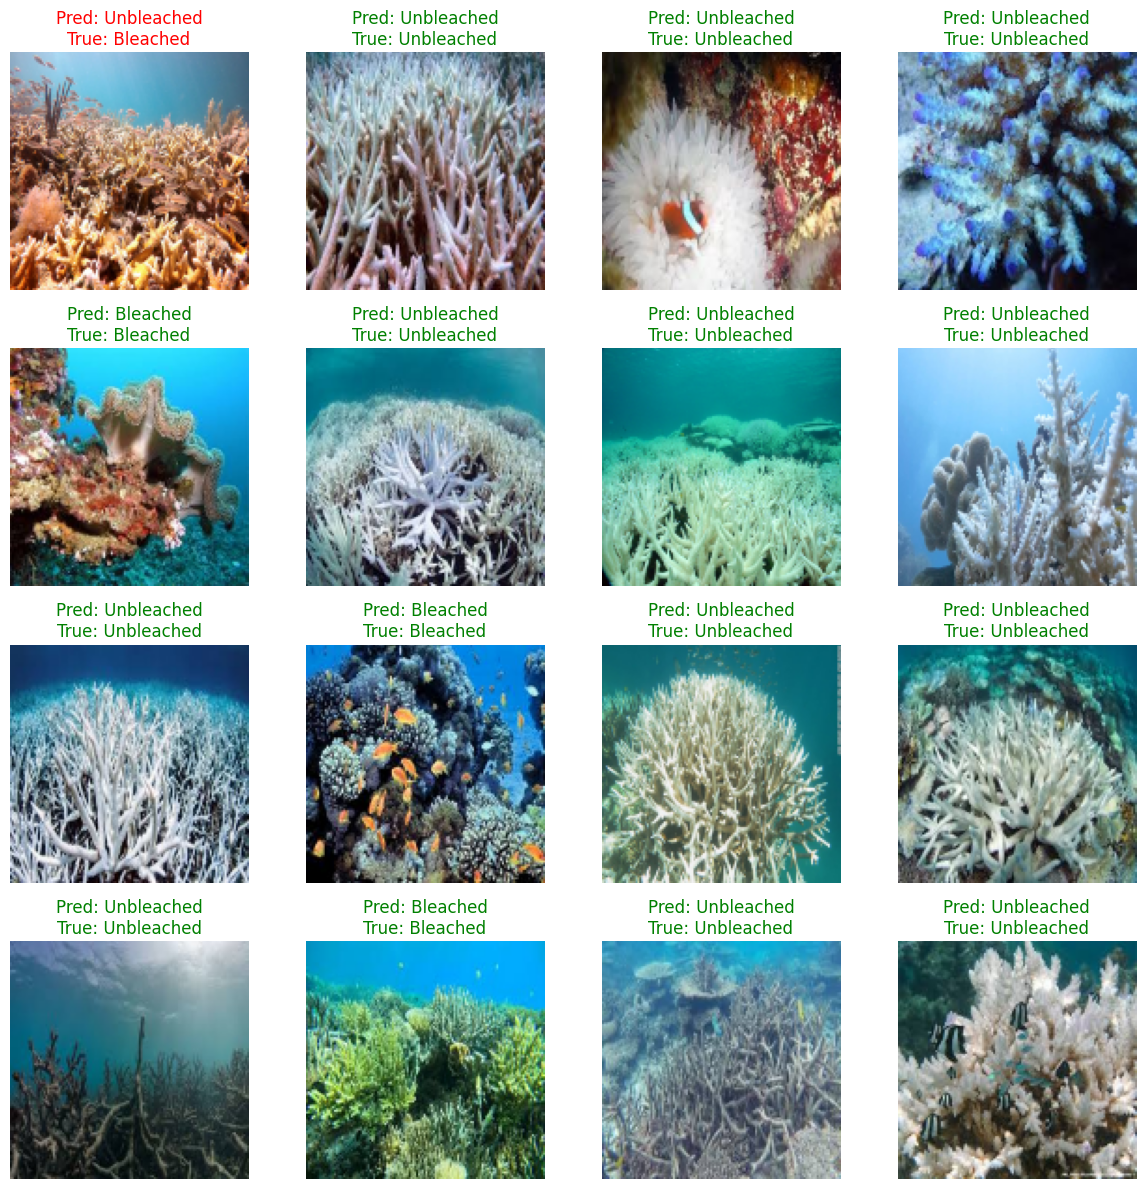

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch from the test set
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    preds = tf.squeeze(preds).numpy()
    break

# Set up grid size
num_images = min(16, len(images))  # 4x4 grid
plt.figure(figsize=(12, 12))

for i in range(num_images):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    true_label = "Bleached" if labels[i].numpy() == 1 else "Unbleached"
    pred_label = "Bleached" if preds[i] >= 0.5 else "Unbleached"
    color = "green" if true_label == pred_label else "red"
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
def get_model6(wd, rate, param_dict):
    print("🔧 Building InceptionV3 (GoogleNet-style) model...")

    base_model = tf.keras.applications.InceptionV3(
        include_top=False,
        weights='imagenet',
        input_shape=(param_dict['IMAGE_SIZE'], param_dict['IMAGE_SIZE'], 3)
    )
    base_model.trainable = False  # Freeze pretrained layers

    inputs = tf.keras.Input(shape=(param_dict['IMAGE_SIZE'], param_dict['IMAGE_SIZE'], 3))
    x = tf.keras.applications.inception_v3.preprocess_input(inputs)
    x = base_model(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization(momentum=0.95, epsilon=0.005)(x)
    x = layers.Dropout(rate)(x)

    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization(momentum=0.95, epsilon=0.005)(x)
    x = layers.Dropout(rate)(x)

    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization(momentum=0.95, epsilon=0.005)(x)
    x = layers.Dropout(rate)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'AUC', 'Precision', 'Recall',
                           tf.keras.metrics.TruePositives(),
                           tf.keras.metrics.TrueNegatives(),
                           tf.keras.metrics.FalsePositives(),
                           tf.keras.metrics.FalseNegatives()])

    print("✅ Model built and compiled.")
    return model


In [ ]:
# === STEP 4: Train the model ===

params = {
    'IMAGE_SIZE': IMAGE_SIZE
}

model = get_model6(wd=1e-4, rate=0.3, param_dict=params)

print("🚀 Starting training...")

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=50)

🔧 Building InceptionV3 (GoogleNet-style) model...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
✅ Model built and compiled.
🚀 Starting training...
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - AUC: 0.5470 - Precision: 0.4611 - Recall: 0.5283 - accuracy: 0.5266 - false_negatives_12: 27.4444 - false_positives_12: 36.0000 - loss: 1.0033 - true_negatives_12: 48.6667 - true_positives_12: 40.3333 - val_AUC: 0.9018 - val_Precision: 0.7000 - val_Recall: 0.9130 - val_accuracy: 0.7800 - val_false_negatives_12: 2.0000 - val_false_positives_12: 9.0000 - val_loss: 0.5773 - val_true_negatives_12: 18.0000 - val_true_positives_12: 21.0000
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - AUC: 0.9476 - Precision: 0.8231 - Recall: 0.9201 - accuracy: 0.8761 - false_negatives_12: 5.4444 - false_positives_12: 11.1111 - loss: 0.4373 - true_negatives_12: 72.4444 - true_positives_12: 63.4444 - val_AUC: 0.9742 - val_Precision: 0.7419 - val_Recall: 1.0000 - val_accuracy: 0.8400 - val_false_negatives_1

In [ ]:
# Evaluate model
eval_results = model.evaluate(test_ds, return_dict=True)

# Print evaluation metrics in table format
print("\n📋 Evaluation Results:")
print("{:<25} {:<10}".format("Metric", "Value"))
print("-" * 35)
for k, v in eval_results.items():
    print("{:<25} {:.4f}".format(k, v))


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - AUC: 0.9845 - Precision: 0.9156 - Recall: 0.7882 - accuracy: 0.8615 - false_negatives_12: 4.6667 - false_positives_12: 1.6667 - loss: 0.5430 - true_negatives_12: 22.6667 - true_positives_12: 17.6667

📋 Evaluation Results:
Metric                    Value     
-----------------------------------
AUC                       0.9855
Precision                 0.9091
Recall                    0.8000
accuracy                  0.8704
false_negatives_12        5.0000
false_positives_12        2.0000
loss                      0.5071
true_negatives_12         27.0000
true_positives_12         20.0000


In [ ]:
def get_model7(wd, rate, param_dict):
    print("🔧 Building InceptionV3 + Self-Attention model...")

    base_model = tf.keras.applications.InceptionV3(
        include_top=False,
        weights='imagenet',
        input_shape=(param_dict['IMAGE_SIZE'], param_dict['IMAGE_SIZE'], 3)
    )
    base_model.trainable = False  # freeze pretrained layers

    inputs = tf.keras.Input(shape=(param_dict['IMAGE_SIZE'], param_dict['IMAGE_SIZE'], 3))
    x = tf.keras.applications.inception_v3.preprocess_input(inputs)
    x = base_model(x)

    x = SelfAttention(x.shape[-1])(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization(momentum=0.95, epsilon=0.005)(x)
    x = layers.Dropout(rate)(x)

    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization(momentum=0.95, epsilon=0.005)(x)
    x = layers.Dropout(rate)(x)

    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization(momentum=0.95, epsilon=0.005)(x)
    x = layers.Dropout(rate)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'AUC', 'Precision', 'Recall',
                           tf.keras.metrics.TruePositives(),
                           tf.keras.metrics.TrueNegatives(),
                           tf.keras.metrics.FalsePositives(),
                           tf.keras.metrics.FalseNegatives()])

    print("✅ Model built and compiled.")
    return model


In [ ]:
# === STEP 4: Train the model ===

params = {
    'IMAGE_SIZE': IMAGE_SIZE
}

model = get_model7(wd=1e-4, rate=0.3, param_dict=params)

print("🚀 Starting training...")

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=50)

🔧 Building InceptionV3 + Self-Attention model...
✅ Model built and compiled.
🚀 Starting training...
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - AUC: 0.6485 - Precision: 0.5505 - Recall: 0.5933 - accuracy: 0.5925 - false_negatives_14: 26.4444 - false_positives_14: 30.8889 - loss: 0.9301 - true_negatives_14: 51.1111 - true_positives_14: 44.0000 - val_AUC: 0.8712 - val_Precision: 0.8889 - val_Recall: 0.6957 - val_accuracy: 0.8200 - val_false_negatives_14: 7.0000 - val_false_positives_14: 2.0000 - val_loss: 0.6572 - val_true_negatives_14: 25.0000 - val_true_positives_14: 16.0000
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 0.9630 - Precision: 0.8569 - Recall: 0.9126 - accuracy: 0.8896 - false_negatives_14: 6.5556 - false_positives_14: 9.4444 - loss: 0.3824 - true_negatives_14: 73.0000 - true_positives_14: 63.4444 - val_AUC: 0.9308 - val_Precision: 0.8333 - val_Recall: 0.8696 - val_accuracy: 0.8600 - val_false_negatives_14: 3.0000 - val_false_positives_14: 4.0000 - val_loss

In [ ]:
# Evaluate model
eval_results = model.evaluate(test_ds, return_dict=True)

# Print evaluation metrics in table format
print("\n📋 Evaluation Results:")
print("{:<25} {:<10}".format("Metric", "Value"))
print("-" * 35)
for k, v in eval_results.items():
    print("{:<25} {:.4f}".format(k, v))


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - AUC: 0.9618 - Precision: 0.9472 - Recall: 0.8962 - accuracy: 0.9298 - false_negatives_14: 2.3333 - false_positives_14: 1.0000 - loss: 0.5380 - true_negatives_14: 24.3333 - true_positives_14: 19.0000

📋 Evaluation Results:
Metric                    Value     
-----------------------------------
AUC                       0.9586
Precision                 0.9565
Recall                    0.8800
accuracy                  0.9259
false_negatives_14        3.0000
false_positives_14        1.0000
loss                      0.5401
true_negatives_14         28.0000
true_positives_14         22.0000


In [ ]:
def get_model8(wd, rate, param_dict):
    print("🔧 Building AlexNet-style model...")

    inputs = tf.keras.Input(shape=(param_dict['IMAGE_SIZE'], param_dict['IMAGE_SIZE'], 3))

    x = layers.Conv2D(96, kernel_size=11, strides=4, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2)(x)

    x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2)(x)

    x = layers.Conv2D(384, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(384, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2)(x)

    x = layers.Flatten()(x)

    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate)(x)

    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate)(x)

    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'AUC', 'Precision', 'Recall',
                           tf.keras.metrics.TruePositives(),
                           tf.keras.metrics.TrueNegatives(),
                           tf.keras.metrics.FalsePositives(),
                           tf.keras.metrics.FalseNegatives()])

    print("✅ AlexNet-style model built and compiled.")
    return model


In [ ]:
# === STEP 4: Train the model ===

params = {
    'IMAGE_SIZE': IMAGE_SIZE
}

model = get_model8(wd=1e-4, rate=0.3, param_dict=params)

print("🚀 Starting training...")

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=50)

🔧 Building AlexNet-style model...
✅ AlexNet-style model built and compiled.
🚀 Starting training...
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - AUC: 0.7163 - Precision: 0.6611 - Recall: 0.6287 - accuracy: 0.6594 - false_negatives_15: 25.0000 - false_positives_15: 23.6667 - loss: 0.8386 - true_negatives_15: 55.8889 - true_positives_15: 47.8889 - val_AUC: 0.5000 - val_Precision: 0.4600 - val_Recall: 1.0000 - val_accuracy: 0.4600 - val_false_negatives_15: 0.0000e+00 - val_false_positives_15: 27.0000 - val_loss: 199.7563 - val_true_negatives_15: 0.0000e+00 - val_true_positives_15: 23.0000
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - AUC: 0.8922 - Precision: 0.7805 - Recall: 0.8067 - accuracy: 0.8080 - false_negatives_15: 14.4444 - false_positives_15: 16.2222 - loss: 0.5373 - true_negatives_15: 66.1111 - true_positives_15: 55.6667 - val_AUC: 0.5000 - val_Precision: 0.4600 - val_Recall: 1.0000 - val_accuracy: 0.4600 - val_false_negatives_15: 0.0000e+00 - val_false_positives_15: 27

In [ ]:
# Evaluate model
eval_results = model.evaluate(test_ds, return_dict=True)

# Print evaluation metrics in table format
print("\n📋 Evaluation Results:")
print("{:<25} {:<10}".format("Metric", "Value"))
print("-" * 35)
for k, v in eval_results.items():
    print("{:<25} {:.4f}".format(k, v))


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - AUC: 0.9347 - Precision: 0.8993 - Recall: 0.9229 - accuracy: 0.9174 - false_negatives_15: 1.6667 - false_positives_15: 2.3333 - loss: 0.4088 - true_negatives_15: 23.0000 - true_positives_15: 19.6667

📋 Evaluation Results:
Metric                    Value     
-----------------------------------
AUC                       0.9428
Precision                 0.8846
Recall                    0.9200
accuracy                  0.9074
false_negatives_15        2.0000
false_positives_15        3.0000
loss                      0.3962
true_negatives_15         26.0000
true_positives_15         23.0000


In [ ]:
def get_model9(wd, rate, param_dict):
    print("🔧 Building AlexNet + Self-Attention model...")

    inputs = tf.keras.Input(shape=(param_dict['IMAGE_SIZE'], param_dict['IMAGE_SIZE'], 3))

    x = layers.Conv2D(96, kernel_size=11, strides=4, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2)(x)

    x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2)(x)

    x = layers.Conv2D(384, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(384, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2)(x)

    x = SelfAttention(x.shape[-1])(x)  # 🔥 Inject self-attention here

    x = layers.Flatten()(x)

    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate)(x)

    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate)(x)

    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'AUC', 'Precision', 'Recall',
                           tf.keras.metrics.TruePositives(),
                           tf.keras.metrics.TrueNegatives(),
                           tf.keras.metrics.FalsePositives(),
                           tf.keras.metrics.FalseNegatives()])

    print("✅ AlexNet + Self-Attention model built and compiled.")
    return model


In [ ]:
# === STEP 4: Train the model ===

params = {
    'IMAGE_SIZE': IMAGE_SIZE
}

model = get_model9(wd=1e-4, rate=0.3, param_dict=params)

print("🚀 Starting training...")

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=50)

🔧 Building AlexNet + Self-Attention model...
✅ AlexNet + Self-Attention model built and compiled.
🚀 Starting training...
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - AUC: 0.6820 - Precision: 0.5921 - Recall: 0.5991 - accuracy: 0.6485 - false_negatives_16: 27.0000 - false_positives_16: 25.0000 - loss: 0.8983 - true_negatives_16: 59.8889 - true_positives_16: 40.5556 - val_AUC: 0.5000 - val_Precision: 0.4600 - val_Recall: 1.0000 - val_accuracy: 0.4600 - val_false_negatives_16: 0.0000e+00 - val_false_positives_16: 27.0000 - val_loss: 234.1476 - val_true_negatives_16: 0.0000e+00 - val_true_positives_16: 23.0000
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - AUC: 0.7866 - Precision: 0.7234 - Recall: 0.6582 - accuracy: 0.7100 - false_negatives_16: 23.1111 - false_positives_16: 18.6667 - loss: 0.7854 - true_negatives_16: 61.1111 - true_positives_16: 49.5556 - val_AUC: 0.5000 - val_Precision: 0.4600 - val_Recall: 1.0000 - val_accuracy: 0.4600 - val_false_negatives_16: 0.0000e+00 - val_

In [ ]:
# Evaluate model
eval_results = model.evaluate(test_ds, return_dict=True)

# Print evaluation metrics in table format
print("\n📋 Evaluation Results:")
print("{:<25} {:<10}".format("Metric", "Value"))
print("-" * 35)
for k, v in eval_results.items():
    print("{:<25} {:.4f}".format(k, v))


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - AUC: 0.9461 - Precision: 0.7632 - Recall: 0.9525 - accuracy: 0.8368 - false_negatives_16: 1.0000 - false_positives_16: 6.6667 - loss: 0.5494 - true_negatives_16: 18.0000 - true_positives_16: 21.0000

📋 Evaluation Results:
Metric                    Value     
-----------------------------------
AUC                       0.9524
Precision                 0.7500
Recall                    0.9600
accuracy                  0.8333
false_negatives_16        1.0000
false_positives_16        8.0000
loss                      0.5620
true_negatives_16         21.0000
true_positives_16         24.0000


In [ ]:
def get_model10(wd, rate, param_dict):
    print("🔧 Building ColorTexture18 model...")

    inputs = tf.keras.Input(shape=(param_dict['IMAGE_SIZE'], param_dict['IMAGE_SIZE'], 3))

    # Block 1: Color features (convolutions with 64 filters)
    x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    # Block 2: Color features (convolutions with 128 filters)
    x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    # Block 3: Texture features (convolutions with 256 filters)
    x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    # Block 4: Texture features (convolutions with 512 filters)
    x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    # Flatten before fully connected layers
    x = layers.Flatten()(x)

    # Fully connected layers for final classification
    x = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate)(x)

    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate)(x)

    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate)(x)

    # Output layer
    outputs = layers.Dense(1, activation='sigmoid')(x)

    # Build the model
    model = tf.keras.Model(inputs, outputs)

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'AUC', 'Precision', 'Recall',
                           tf.keras.metrics.TruePositives(),
                           tf.keras.metrics.TrueNegatives(),
                           tf.keras.metrics.FalsePositives(),
                           tf.keras.metrics.FalseNegatives()])

    print("✅ ColorTexture18 model built and compiled.")
    return model


In [ ]:
# === STEP 4: Train the model ===

params = {
    'IMAGE_SIZE': IMAGE_SIZE
}

model = get_model10(wd=1e-4, rate=0.3, param_dict=params)

print("🚀 Starting training...")

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=50)

🔧 Building ColorTexture18 model...
✅ ColorTexture18 model built and compiled.
🚀 Starting training...
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - AUC: 0.8185 - Precision: 0.6762 - Recall: 0.6961 - accuracy: 0.7224 - false_negatives_17: 18.8889 - false_positives_17: 18.6667 - loss: 0.8963 - true_negatives_17: 65.2222 - true_positives_17: 49.6667 - val_AUC: 0.5000 - val_Precision: 0.4600 - val_Recall: 1.0000 - val_accuracy: 0.4600 - val_false_negatives_17: 0.0000e+00 - val_false_positives_17: 27.0000 - val_loss: 117.5594 - val_true_negatives_17: 0.0000e+00 - val_true_positives_17: 23.0000
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - AUC: 0.9742 - Precision: 0.9396 - Recall: 0.8957 - accuracy: 0.9188 - false_negatives_17: 7.6667 - false_positives_17: 5.5556 - loss: 0.5585 - true_negatives_17: 72.2222 - true_positives_17: 67.0000 - val_AUC: 0.5000 - val_Precision: 0.4600 - val_Recall: 1.0000 - val_accuracy: 0.4600 - val_false_negatives_17: 0.0000e+00 - val_false_positives_17: 27

In [ ]:
# Evaluate model
eval_results = model.evaluate(test_ds, return_dict=True)

# Print evaluation metrics in table format
print("\n📋 Evaluation Results:")
print("{:<25} {:<10}".format("Metric", "Value"))
print("-" * 35)
for k, v in eval_results.items():
    print("{:<25} {:.4f}".format(k, v))


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - AUC: 0.9867 - Precision: 1.0000 - Recall: 0.8154 - accuracy: 0.9174 - false_negatives_17: 4.0000 - false_positives_17: 0.0000e+00 - loss: 0.6741 - true_negatives_17: 25.6667 - true_positives_17: 17.0000

📋 Evaluation Results:
Metric                    Value     
-----------------------------------
AUC                       0.9800
Precision                 1.0000
Recall                    0.8000
accuracy                  0.9074
false_negatives_17        5.0000
false_positives_17        0.0000
loss                      0.7329
true_negatives_17         29.0000
true_positives_17         20.0000


In [ ]:
def get_model11(wd, rate, param_dict):
    print("🔧 Building ColorTexture18 + ResNet50 model...")

    input_shape = (param_dict['IMAGE_SIZE'], param_dict['IMAGE_SIZE'], 3)
    inputs = tf.keras.Input(shape=input_shape)

    # 🔹 ResNet50 branch
    resnet_base = tf.keras.applications.ResNet50(
        include_top=False, weights='imagenet', input_shape=input_shape)
    resnet_base.trainable = False
    x1 = resnet_base(inputs)
    x1 = layers.GlobalAveragePooling2D()(x1)

    # 🔹 ColorTexture18 branch
    x2 = layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.MaxPooling2D(2)(x2)

    x2 = layers.Conv2D(128, 3, padding='same', activation='relu')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.MaxPooling2D(2)(x2)

    x2 = layers.Conv2D(256, 3, padding='same', activation='relu')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.MaxPooling2D(2)(x2)

    x2 = layers.Conv2D(512, 3, padding='same', activation='relu')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.GlobalAveragePooling2D()(x2)

    # 🔗 Merge both branches
    x = layers.Concatenate()([x1, x2])

    # 🔸 Fully connected layers
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate)(x)

    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate)(x)

    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'AUC', 'Precision', 'Recall',
                           tf.keras.metrics.TruePositives(),
                           tf.keras.metrics.TrueNegatives(),
                           tf.keras.metrics.FalsePositives(),
                           tf.keras.metrics.FalseNegatives()])
    print("✅ Model built and compiled.")
    return model


In [ ]:
# === STEP 4: Train the model ===

params = {
    'IMAGE_SIZE': IMAGE_SIZE
}

model = get_model11(wd=1e-4, rate=0.3, param_dict=params)

print("🚀 Starting training...")

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=50)

🔧 Building ColorTexture18 + ResNet50 model...
✅ Model built and compiled.
🚀 Starting training...
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - AUC: 0.8266 - Precision: 0.7543 - Recall: 0.7892 - accuracy: 0.7653 - false_negatives_18: 12.7778 - false_positives_18: 16.0000 - loss: 0.6398 - true_negatives_18: 64.6667 - true_positives_18: 59.0000 - val_AUC: 0.5000 - val_Precision: 0.4600 - val_Recall: 1.0000 - val_accuracy: 0.4600 - val_false_negatives_18: 0.0000e+00 - val_false_positives_18: 27.0000 - val_loss: 17.6713 - val_true_negatives_18: 0.0000e+00 - val_true_positives_18: 23.0000
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 0.9947 - Precision: 0.9448 - Recall: 0.9783 - accuracy: 0.9638 - false_negatives_18: 1.6667 - false_positives_18: 2.8889 - loss: 0.2464 - true_negatives_18: 80.0000 - true_positives_18: 67.8889 - val_AUC: 0.5000 - val_Precision: 0.4600 - val_Recall: 1.0000 - val_accuracy: 0.4600 - val_false_negatives_18: 0.0000e+00 - val_false_positives_18: 27.0000

In [ ]:
# Evaluate model
eval_results = model.evaluate(test_ds, return_dict=True)

# Print evaluation metrics in table format
print("\n📋 Evaluation Results:")
print("{:<25} {:<10}".format("Metric", "Value"))
print("-" * 35)
for k, v in eval_results.items():
    print("{:<25} {:.4f}".format(k, v))


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - AUC: 1.0000 - Precision: 1.0000 - Recall: 0.8783 - accuracy: 0.9421 - false_negatives_18: 2.6667 - false_positives_18: 0.0000e+00 - loss: 0.2135 - true_negatives_18: 24.6667 - true_positives_18: 19.3333

📋 Evaluation Results:
Metric                    Value     
-----------------------------------
AUC                       1.0000
Precision                 1.0000
Recall                    0.8800
accuracy                  0.9444
false_negatives_18        3.0000
false_positives_18        0.0000
loss                      0.2234
true_negatives_18         29.0000
true_positives_18         22.0000


In [ ]:
from tensorflow.keras import layers, regularizers, Model
import tensorflow as tf

class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(SelfAttention, self).__init__()
        self.q = layers.Dense(units)
        self.k = layers.Dense(units)
        self.v = layers.Dense(units)
        self.softmax = layers.Softmax(axis=-1)

    def call(self, inputs):
        q = self.q(inputs)
        k = self.k(inputs)
        v = self.v(inputs)
        score = tf.matmul(q, k, transpose_b=True)
        score /= tf.math.sqrt(tf.cast(tf.shape(k)[-1], tf.float32))
        weights = self.softmax(score)
        return tf.matmul(weights, v)

def get_model12(wd, rate, param_dict):
    print("🔧 Building ColorTexture18 + ResNet50 + Self-Attention model...")

    input_shape = (param_dict['IMAGE_SIZE'], param_dict['IMAGE_SIZE'], 3)
    inputs = tf.keras.Input(shape=input_shape)

    # 🔹 ResNet50 branch
    resnet_base = tf.keras.applications.ResNet50(
        include_top=False, weights='imagenet', input_shape=input_shape)
    resnet_base.trainable = False
    x1 = resnet_base(inputs)
    x1 = layers.GlobalAveragePooling2D()(x1)

    # 🔹 ColorTexture18 branch
    x2 = layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.MaxPooling2D(2)(x2)

    x2 = layers.Conv2D(128, 3, padding='same', activation='relu')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.MaxPooling2D(2)(x2)

    x2 = layers.Conv2D(256, 3, padding='same', activation='relu')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.MaxPooling2D(2)(x2)

    x2 = layers.Conv2D(512, 3, padding='same', activation='relu')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.GlobalAveragePooling2D()(x2)

    # 🔗 Merge both branches
    x = layers.Concatenate()([x1, x2])  # shape: (None, 2048 + 512) = (None, 2560)

    # 🧠 Self-Attention on reshaped features
    x = layers.Reshape((1, x.shape[-1]))(x)  # (None, 1, 2560)
    x = SelfAttention(units=256)(x)         # (None, 1, 256)
    x = layers.Flatten()(x)                 # (None, 256)

    # 🔸 Fully connected layers
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate)(x)

    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate)(x)

    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'AUC', 'Precision', 'Recall',
                           tf.keras.metrics.TruePositives(),
                           tf.keras.metrics.TrueNegatives(),
                           tf.keras.metrics.FalsePositives(),
                           tf.keras.metrics.FalseNegatives()])
    print("✅ Model built and compiled.")
    return model


In [ ]:
# === STEP 4: Train the model ===

params = {
    'IMAGE_SIZE': IMAGE_SIZE
}

model = get_model12(wd=1e-4, rate=0.3, param_dict=params)

print("🚀 Starting training...")

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=50)

🔧 Building ColorTexture18 + ResNet50 + Self-Attention model...
✅ Model built and compiled.
🚀 Starting training...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - AUC: 0.7781 - Precision: 0.6280 - Recall: 0.7352 - accuracy: 0.7050 - false_negatives_20: 13.3333 - false_positives_20: 23.6667 - loss: 0.7103 - true_negatives_20: 62.1111 - true_positives_20: 53.3333 - val_AUC: 0.5000 - val_Precision: 0.4600 - val_Recall: 1.0000 - val_accuracy: 0.4600 - val_false_negatives_20: 0.0000e+00 - val_false_positives_20: 27.0000 - val_loss: 16.5438 - val_true_negatives_20: 0.0000e+00 - val_true_positives_20: 23.0000
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 0.9864 - Precision: 0.9367 - Recall: 0.9747 - accuracy: 0.9576 - false_negatives_20: 2.2222 - false_positives_20: 4.7778 - loss: 0.2219 - true_negatives_20: 77.0000 - true_positives_20: 68.4444 - val_AUC: 0.5000 - val_Precision: 0.4600 - val_Recall: 1.0000 - val_accuracy: 0.4600 - val_false_negatives_20: 0.0000e+00 - val_false_positives_20: 27.0000 - val_loss: 12.3058 - val_true_negatives_20: 0.0000e+00 - val_true_positives_20: 23.0000
Epoch 3/50
8/8 ━━━

In [ ]:
# Evaluate model
eval_results = model.evaluate(test_ds, return_dict=True)

# Print evaluation metrics in table format
print("\n📋 Evaluation Results:")
print("{:<25} {:<10}".format("Metric", "Value"))
print("-" * 35)
for k, v in eval_results.items():
    print("{:<25} {:.4f}".format(k, v))


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - AUC: 1.0000 - Precision: 1.0000 - Recall: 0.9733 - accuracy: 0.9877 - false_negatives_20: 0.6667 - false_positives_20: 0.0000e+00 - loss: 0.1229 - true_negatives_20: 24.6667 - true_positives_20: 21.3333

📋 Evaluation Results:
Metric                    Value     
-----------------------------------
AUC                       1.0000
Precision                 1.0000
Recall                    0.9600
accuracy                  0.9815
false_negatives_20        1.0000
false_positives_20        0.0000
loss                      0.1242
true_negatives_20         29.0000
true_positives_20         24.0000
